In [1]:
import cv2
import os
import shutil
import pandas as pd
import numpy as np

from keras.preprocessing.image import img_to_array, load_img
from matplotlib import pyplot as plt

from datetime import datetime
#from keras.preprocessing.image import ImageDataGenerator

In [2]:
start_time = datetime.now()

In [18]:
df_full = pd.read_csv("../data/preprocessed/df_mole_merged.csv")
df_full.sample(5)

,id,file_path,kat.Diagnose,maligne
2622,F704,../data/Mole_Data/SET_F/F704.BMP,1,False
2246,F318,../data/Mole_Data/SET_F/F318.BMP,2,True
204,D215,../data/Mole_Data/SET_D/D215.BMP,1,False
1062,E86,../data/Mole_Data/SET_E/E86.BMP,1,False
1556,E607,../data/Mole_Data/SET_E/E607.BMP,2,True


In [4]:
#df_full.shape

## Image classification

In [5]:
DESTINATION_PATH = "../data/preprocessed/img/"

Copy image to the destination path
Structure : <br/>
`
DESTINATION_PATH
        +--- Train
        |   +-- Begnin
        |   +-- Maligne
        +--- Validation
        |   +-- Begnin
        |   +-- Maligne
        +--- Test
            +-- Begnin
            +-- Maligne`

In [6]:
def copy_images_to_directory(file_paths, destination, data_augmentation=False):
    """
    This procedure copy all give file to a specific destination.
    If the destination path doesn't exist. This one will be
    automatically created.
    
    The file are copied in a iteration.
    If some files have the same name, the new file will override 
    the previous one.
    
    Parameters:
    -----------
    file_paths  : the iterable list of file paths to move to the destination
    destination : a string representing the destination path 
    """
    
    # Check if the destination exist
    # or create it
    if not os.path.exists(destination):
        os.makedirs(destination)
    
    # Code duplication to avoid to check this condition
    # for each item
    if not data_augmentation:
        # Only copy the files to the new destination
        for file_path in file_paths:
            file_name = file_path.split("/")[-1]
            shutil.copy(file_path, f"{destination}{file_name}")
    else:
        # Create 3 new versions of the original image
        # One horizontal flip
        # Two vertical flip (original , horizontal_flip
        # and copy them to the destination
        for file_path in file_paths:
            file_name = file_path.split("/")[-1]
            fname, ext = os.path.splitext(file_name) 
            new_path = f"{destination}{fname}_A{ext}"
            shutil.copy(file_path, new_path)
            
            # Data Augmentation
            img = cv2.imread(new_path)
            # Horizontal flip
            flippedimage = cv2.flip(img, 1)
            cv2.imwrite(f"{destination}{fname}_B{ext}", flippedimage)
            # Vertical flip
            vflippedimage = cv2.flip(img, 0)
            cv2.imwrite(f"{destination}{fname}_C{ext}", vflippedimage)
            vflippedimage = cv2.flip(flippedimage, 0)
            cv2.imwrite(f"{destination}{fname}_D{ext}", vflippedimage)

#### Case 1 : Begnin case

In [7]:
filter_begnin = df_full["maligne"] == False

In [8]:
dir_begnin = f"{DESTINATION_PATH}Train/Begnin/"

In [9]:
copy_images_to_directory(df_full[filter_begnin]["file_path"], dir_begnin)

#### Case 2 : Maligne case
Need data augmentation
All picture will become 4 pictures :
- 1 : Original
- 2 : Horizontal flip of 1
- 3 : Vertical flip of 1
- 4 : Vertical flip of 2

In [10]:
dir_maligne = f"{DESTINATION_PATH}Train/Maligne/"

In [11]:
copy_images_to_directory(df_full[~filter_begnin]["file_path"], dir_maligne, data_augmentation=True)

### Split new image dataset to "Train/Test/Validation"

In [12]:
# Read the train directory with all images
_, _, X_begnin = next(os.walk(dir_begnin))
_, _, X_maligne = next(os.walk(dir_maligne))

In [13]:
print(len(X_begnin))
print(X_begnin[0])
print(len(X_maligne))
print(X_maligne[0])

2271
D876.BMP
2516
D855_A.BMP


In [14]:
def split_directory_train_test_validation(
    source_dir,
    test_dir, 
    validation_dir, 
    test_split=.2,
    validation_split=.2,
    shuffle=True
):
    # list all files in the source
    _, _, X = next(os.walk(source_dir))
    
    # convert the file list to np array
    X = np.array(X)
    
    # compute the test and validation size
    cnt_items = X.shape[0]
    test_size = int(round(cnt_items*test_split, 0))
    val_size = int(round(cnt_items*validation_split, 0))
    
    if shuffle:
        s = np.arange(cnt_items)
        np.random.shuffle(s)
        
        X_test = X[s[0:test_size]]
        X_val  = X[s[test_size:test_size+val_size]]
    else:
        X_test = X[0:test_size]
        X_val  = X[test_size:test_size+val_size]
    
    # Copy the selected files to
    # the destination folders
    if X_test.shape[0] :
        # Create the dest if not exist
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
        # Move the files
        for f in X_test:
            shutil.move(source_dir+f, test_dir+f)
    if X_val.shape[0] :
        # Create the dest if not exist
        if not os.path.exists(validation_dir):
            os.makedirs(validation_dir)
        # Move the files
        for f in X_val:
            shutil.move(source_dir+f, validation_dir+f)

In [15]:
split_directory_train_test_validation(dir_begnin, 
                                      f"{DESTINATION_PATH}Test/Begnin/", 
                                      f"{DESTINATION_PATH}Validation/Begnin/")

In [16]:
split_directory_train_test_validation(dir_maligne, 
                                      f"{DESTINATION_PATH}Test/Maligne/", 
                                      f"{DESTINATION_PATH}Validation/Maligne/")

In [17]:
end_time = datetime.now()


In [18]:
duration = end_time - start_time

print("Image classification done in", duration)

Image classification done in 0:00:26.643306


### Sample of data augmentation

In [20]:
img = cv2.imread(df_full["file_path"][0])
print(type(img))
# Horizontal flip
flippedimage = cv2.flip(img, 1)
# Vertical flip
vflippedimage = cv2.flip(img, 0)
vflippedimage2 = cv2.flip(flippedimage, 0)

<class 'numpy.ndarray'>


<Figure size 720x720 with 0 Axes>

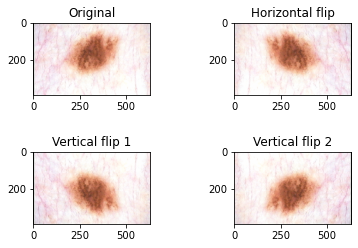

In [33]:
fig=plt.figure(figsize=(10, 10))
ncols = 2
nrows = 2


fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original')
axs[0, 1].imshow(cv2.cvtColor(flippedimage, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Horizontal flip')
axs[1, 0].imshow(cv2.cvtColor(vflippedimage, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title('Vertical flip 1')
axs[1, 1].imshow(cv2.cvtColor(vflippedimage2, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Vertical flip 2')
fig.tight_layout(pad=3)
plt.show()